What happens when we pass a long binary input string through multiple linear systems with different $\tau$'s?

In [1]:
%matplotlib inline
from itertools import product as cprod
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_font_size

DT = .005

R_BIN = np.linspace(0, 1, 17)
R_BIN2 = np.linspace(0, 1, 33)

We start with a binary input stream containing $n$ segments of length $\Delta T$ with $n \Delta T = T$. There are $2^n$ possible input "strings", as each time window can be either $\{0, 1\}$.

In [2]:
def s2cur(s, step):
    n = len(s)
    
    t = np.arange(0, n*step, DT)
    cur = np.zeros(len(t))
    
    istep = int(round(step/DT))
    
    for istart in s.nonzero()[0]*istep:
        cur[istart:istart+istep] = 1
        
    return cur

In [3]:
n = 256
step = 1/16
q = .5

n_in = 100000
tau_1 = .087
taus = [.001, .05, .07, tau_1, .2, 1, 2, 4]

ss = np.concatenate([np.random.rand(n_in, n) < q, np.ones((1, n), bool)])
curs = np.array([s2cur(s, step=step) for s in ss])
t = np.arange(len(curs[0])) * DT

h_1 = np.exp(-t/tau_1)
r_1 = np.array([h_1[::-1]@cur for cur in curs])
r_1 /= np.max(r_1)

rs = []

for tau in taus:
    sys.stdout.write('.')
    h = np.exp(-t/tau)
    r = np.array([h[::-1]@cur for cur in curs])
    r /= np.max(r)
    rs.append(r)

........

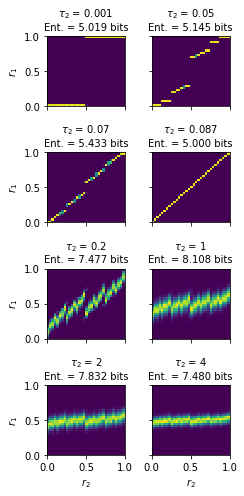

In [4]:
fig, axs = plt.subplots(4, 2, figsize=(3.5, 7), sharex=True, sharey=True, tight_layout=True)

for cax, (ax, tau_2) in enumerate(zip(axs.flatten(), taus)):
    r_2 = rs[cax]
    
    cts = np.histogram2d(r_1, r_2, bins=[R_BIN2, R_BIN2])[0]
    p = cts / cts.sum()
    ent = stats.entropy(p.flatten(), base=2)
    
    ax.hist2d(r_1, r_2, bins=[R_BIN2, R_BIN2])
    title = fr'$\tau_2$ = {tau_2}' + '\n' + fr'Ent. = {ent:.3f} bits'
    ax.set_title(title)
    
for ax in axs[-1, :]:
    ax.set_xlabel(r'$r_2$')
    
for ax in axs[:, 0]:
    ax.set_ylabel(r'$r_1$')

set_font_size(axs, 10)
fig.savefig('plots/p_r_1_r_2_tau_2_sweep.pdf')

In [29]:
n_bins = [16, 32, 64, 128, 256]

taus_2 = np.logspace(-3, .6021, 121)
ents_all = np.nan * np.zeros((len(n_bins), len(taus_2)))

for ctau, tau_2 in enumerate(taus_2):
    sys.stdout.write('.')
    h_2 = np.exp(-t/tau_2)
    r_2 = np.array([h_2[::-1]@cur for cur in curs])
    r_2 /= np.max(r_2)
 
    for cn_bin, n_bin in enumerate(n_bins):
        r_bin = np.linspace(0, 1, n_bin+1)
        cts = np.histogram2d(r_1, r_2, bins=[r_bin, r_bin])[0]
        p = cts / cts.sum()

        ents_all[cn_bin, ctau] = stats.entropy(p.flatten(), base=2)
        
print('')

taus_2_zoom = np.linspace(.07, .1, 61)
ents_all_zoom = np.nan * np.zeros((len(n_bins), len(taus_2_zoom)))

for ctau, tau_2 in enumerate(taus_2_zoom):
    sys.stdout.write('.')
    h_2 = np.exp(-t/tau_2)
    r_2 = np.array([h_2[::-1]@cur for cur in curs])
    r_2 /= np.max(r_2)
 
    for cn_bin, n_bin in enumerate(n_bins):
        r_bin = np.linspace(0, 1, n_bin+1)
        cts = np.histogram2d(r_1, r_2, bins=[r_bin, r_bin])[0]
        p = cts / cts.sum()

        ents_all_zoom[cn_bin, ctau] = stats.entropy(p.flatten(), base=2)

.........................................................................................................................
.............................................................

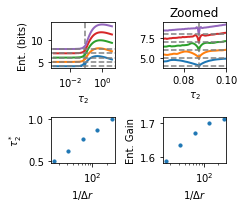

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(3.5, 3), tight_layout=True)
axs[0, 0].axvline(tau_1, ls='--', color='gray')

tau_2_stars = []
ents_max = []

for n_bin, ents in zip(n_bins, ents_all):
    tau_2_stars.append(taus_2[np.argmax(ents)])
    ents_max.append(np.max(ents))

    axs[0, 0].semilogx(taus_2, ents, lw=2)
    axs[0, 0].axhline(np.log2(n_bin), ls='--', color='gray')
    
axs[0, 0].set_xlabel(r'$\tau_2$')
axs[0, 0].set_ylabel('Ent. (bits)')

axs[0, 1].axvline(tau_1, ls='--', color='gray')

for n_bin, ents in zip(n_bins, ents_all_zoom):

    axs[0, 1].plot(taus_2_zoom, ents, lw=2)
    axs[0, 1].axhline(np.log2(n_bin), ls='--', color='gray')

axs[0, 1].set_xlim(.07, .1)
axs[0, 1].set_xlabel(r'$\tau_2$')
axs[0, 1].set_title('Zoomed')

axs[1, 0].scatter(n_bins, tau_2_stars, s=10)
axs[1, 0].set_xscale('log')

axs[1, 0].set_xlabel(r'$1/\Delta r$')
axs[1, 0].set_ylabel(r'$\tau_2^*$')

axs[1, 1].scatter(n_bins, np.array(ents_max)/np.log2(n_bins), s=10)
axs[1, 1].set_xscale('log')

axs[1, 1].set_xlabel(r'$1/\Delta r$')
axs[1, 1].set_ylabel('Ent. Gain')

fig.savefig('plots/ent_tau_2_delta_r.pdf')